# A Deep Dive into the RL Trader Agent

Welcome to this comprehensive guide on the `rl_trading_project`! This notebook is designed for a novice user, aiming to demystify the world of Reinforcement Learning (RL) for algorithmic trading. We will break down complex financial and technical concepts into simple, understandable pieces.

**Our Goal:** By the end of this notebook, you will understand:
1.  **Core Concepts:** The basic financial ideas (like slippage, positions) and RL principles (agent, environment, reward) that power the system.
2.  **The Algorithms:** How advanced RL algorithms like Dueling DQN and PPO work under the hood, including their strengths and weaknesses.
3.  **Practical Application:** How to use the `rl_trading_project` to train a multi-asset portfolio management agent from scratch on realistic, simulated data.
4.  **Options Trading:** A deep dive into how options work, how they can be used for hedging or speculation, and how to combine them with other assets.
5.  **The Frontier:** A research-backed look at the latest advancements for improving financial RL agents.

## Part 1: The Core Concepts (Finance & RL)

Before we write any code, let's build a solid foundation. An RL trading system is a conversation between two components: the **Agent** (the trader) and the **Environment** (the market).

### Financial Building Blocks

The Environment's job is to simulate the financial market as realistically as possible. Here are the key concepts it models:

*   **OHLCV Data:** This is the lifeblood of most financial analysis. For any time period (e.g., one minute), we have:
    *   **O**pen: The price at the start of the period.
    *   **H**igh: The highest price during the period.
    *   **L**ow: The lowest price during the period.
    *   **C**lose: The price at the end of the period.
    *   **V**olume: How many units were traded.

*   **Actions & Positions:**
    *   **Long:** You *buy* an asset, believing its price will go up. Your position is positive (e.g., +10 shares).
    *   **Short:** You *sell* a borrowed asset, believing its price will go down. You plan to buy it back later at a lower price. Your position is negative (e.g., -10 shares).
    *   **Position:** The quantity of an asset you currently hold.
    *   **Portfolio:** A collection of all your positions across different assets.

*   **The Reality of Trading Costs:** In the real world, trading isn't free. Our environment simulates this to prevent the agent from learning unrealistic, hyper-active strategies.
    *   **Commission:** A fee you pay to the broker for executing your trade. It's usually a small percentage of the trade's value.
    *   **Slippage:** This is a subtle but crucial concept. When you place a large order, you can affect the market price. If you buy, the price you actually get might be slightly *higher* than you expected. If you sell, it might be slightly *lower*. This difference is slippage. It's the market moving against you because of your own actions.

### Reinforcement Learning Building Blocks

RL is about learning through trial and error. The process is a continuous loop:

![Agent-Environment Loop](https://miro.medium.com/max/1400/1*8CSo2kftq2u9s1P1i2249A.png)
*Image from Sutton & Barto, "Reinforcement Learning: An Introduction"*

1.  **State (Observation):** The Agent observes the current state of the Environment. In our case, this is the recent price history (the OHLCV window) and the agent's own portfolio state (cash balance, current positions).
2.  **Action:** Based on the state, the Agent decides to take an action. For a portfolio, this action is a vector of target allocations, e.g., `[0.5, -0.2, 0.3]` meaning "I want to be 50% long Asset 1, 20% short Asset 2, and 30% long Asset 3".
3.  **Reward:** The Environment receives the agent's action, simulates it, and moves to a new state. It then gives the Agent a reward signal. A simple reward is the profit or loss (PnL) from that step. A better reward might also penalize the agent for taking on too much risk.

The Agent's one and only goal is to **maximize the cumulative reward** over the long run. It does this by learning a **policy**—a strategy that maps states to actions.

## Part 2: A Tale of Two Algorithms (DQN vs. PPO)

Our project includes two powerful, modern RL algorithms. They take different approaches to solving the same problem.

### Dueling Deep Q-Networks (Dueling DQN)

Dueling DQN is a **value-based** method. It's focused on figuring out how good each possible action is in a given state.

**How it Works:**
1.  **Q-Value:** At its heart, it tries to learn a function called `Q(state, action)`. This function predicts the total future reward you'll get if you take a certain `action` from a given `state` and then follow the optimal policy forever after.
2.  **Deep Q-Network (DQN):** Since the number of states is infinite, we can't use a simple lookup table. Instead, we use a deep neural network to approximate the Q-function. The network takes the state as input and outputs a Q-value for *every possible action*.
3.  **The Dueling Architecture:** This is the clever trick. Instead of one network predicting the Q-value directly, it splits the network into two heads:
    *   **Value Head:** Estimates how good it is to be in the current state (`V(s)`). It doesn't care about the action.
    *   **Advantage Head:** Estimates how much better a given action is compared to the average action in that state (`A(s, a)`).
    The final Q-value is then combined from these two heads: `Q(s, a) = V(s) + (A(s, a) - mean(A(s, all_actions)))`. This helps the network learn more efficiently, especially when many actions have similar value.
4.  **Replay Buffer:** The agent stores its experiences (state, action, reward, next_state) in a large memory called a Replay Buffer. During training, it samples random mini-batches from this buffer. This breaks the correlation between consecutive steps, making the training process much more stable and efficient.
5.  **Prioritized Experience Replay (PER) buffer:** This samples transitions with a probability proportional to their TD error, allowing the agent to focus on the most informative experiences. This involves a SumTree data structure for efficient sampling.

**Benefits:**
✅ Very stable and reliable for problems with a **discrete** (and small) set of actions (e.g., Buy, Sell, Hold).
✅ The concept of a Q-value is intuitive and easy to understand.

**Risks & Limitations:**
❌ **Cannot handle continuous actions.** It's impossible to output a Q-value for every point in a continuous range. This makes it unsuitable for portfolio allocation, where the action is "how much" to buy/sell.
❌ Can be slow to learn as it needs to evaluate every single action.

### Proximal Policy Optimization (PPO)

PPO is a **policy-based** method and is the current workhorse of many state-of-the-art RL applications. It directly learns the policy (the mapping from state to action).

**How it Works:**
1.  **Actor-Critic Model:** PPO uses two neural networks:
    *   **The Actor (Policy Network):** This network takes the state as input and directly outputs the action (or the parameters of a probability distribution for the action, e.g., mean and standard deviation for a continuous action).
    *   **The Critic (Value Network):** This network is just like the Value Head in Dueling DQN. It takes the state as input and estimates how good it is to be in that state (`V(s)`). Its job is to help the Actor learn better.
2.  **The Core Idea - Trust Region Optimization:** The biggest problem with older policy-based methods was instability. A single bad update could collapse the policy. PPO solves this with a clever objective function.
3.  **The PPO Clip Objective:** This is the secret sauce. When updating the policy, PPO calculates the ratio of the probability of an action under the *new* policy versus the *old* policy. 
    *   If this ratio is too large (the new policy is very different), PPO **clips** it, preventing the update from being too drastic.
    *   **In simple terms: PPO forces the agent to take small, conservative steps, ensuring it doesn't stray too far from a good policy it has already found. It operates in a "trust region" around its current policy.**

**Benefits:**
✅ **Excellent for continuous action spaces**, making it perfect for portfolio allocation.
✅ Much more sample-efficient than many other algorithms.
✅ Strikes a great balance between performance, stability, and ease of implementation.

**Risks & Limitations:**
❌ Can be more complex to tune due to its multiple components and hyperparameters.
❌ The training process can sometimes be noisy, though it's generally very robust.

## Part 3: The `rl_trading_project` in Action - A Practical Walkthrough

Now, let's put theory into practice. We will train a PPO agent to manage a portfolio of three different assets. This entire example is self-contained.

### Setup: Imports and Environment

First, we import the necessary libraries and classes from our project. Ensure you have run `uv pip install -e .` from the project's root directory.

In [3]:
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt

# Import core components from our project
from rl_trading_project.agents import PPOAgent
from rl_trading_project.envs import PortfolioEnv, GymWrapper
from rl_trading_project.options import bs_price

# Set a seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Setup Complete!")

Setup Complete!


### Step 1: Generating Realistic Multi-Asset Data

We need data to train on. We'll create a function to generate a DataFrame containing simulated price data for multiple assets. The key is to make it realistic:
*   Assets will have different trends (drifts) and risk profiles (volatilities).
*   Their movements will be partially correlated, just like real stocks in a market.

The final DataFrame will use a `pd.MultiIndex` on `(timestamp, asset)`, which is the required format for our `PortfolioEnv`.

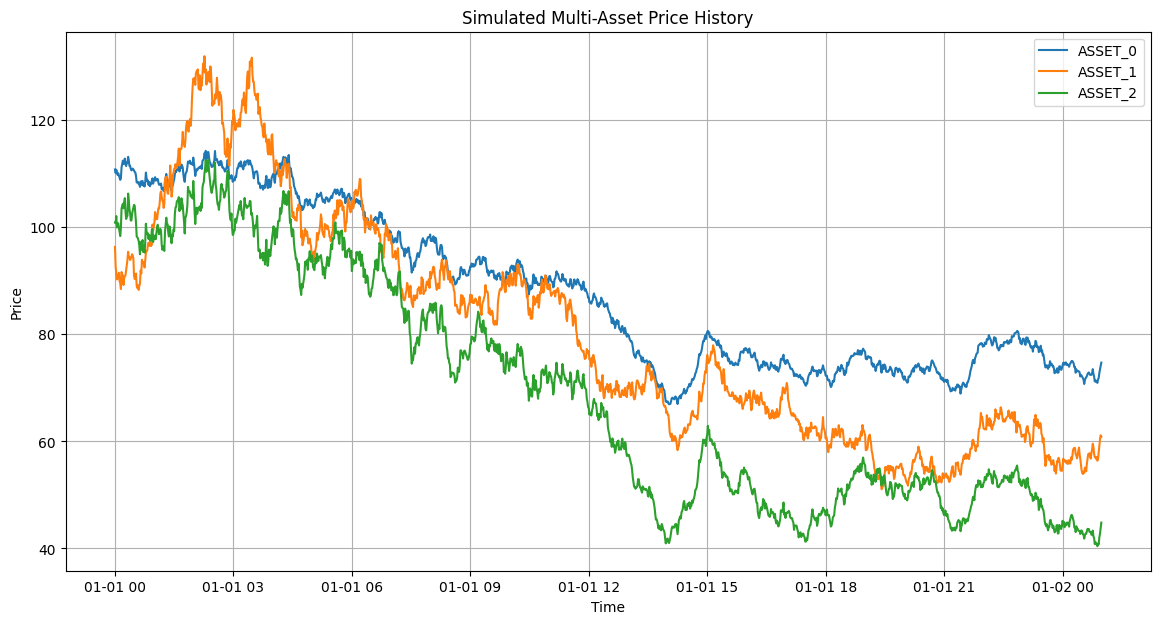

In [4]:
def make_multi_asset_df(n_assets=3, n_steps=1000, seed=42):
    """Generates a realistic, multi-indexed DataFrame for multiple assets."""
    rng = np.random.RandomState(seed)
    
    # Create a robust, guaranteed positive-definite random correlation matrix
    A = rng.rand(n_assets, n_assets)
    cov = np.dot(A, A.T)
    np.fill_diagonal(cov, np.diagonal(cov) + 0.1) # Ensure positive definite
    D_inv = np.diag(1 / np.sqrt(np.diag(cov)))
    corr_matrix = np.dot(D_inv, np.dot(cov, D_inv))
    corr_chol = np.linalg.cholesky(corr_matrix)
    
    # Create a correlated random walk from an uncorrelated one
    base_uncorr_walk = rng.normal(loc=0.0, scale=1.0, size=(n_steps, n_assets))
    corr_walk = np.dot(base_uncorr_walk, corr_chol.T)

    all_dfs = []
    assets = [f'ASSET_{i}' for i in range(n_assets)]
    
    for i, asset in enumerate(assets):
        # Assign unique drift and volatility to each asset
        drift = rng.uniform(-0.0001, 0.0002) 
        volatility = rng.uniform(0.005, 0.02)
        
        # Create price series from the correlated walk
        price_moves = drift + corr_walk[:, i] * volatility
        initial_price = rng.uniform(80, 120)
        price = initial_price * np.exp(np.cumsum(price_moves))
        
        dates = pd.date_range('2023-01-01', periods=n_steps, freq='min', tz='UTC')
        df = pd.DataFrame({
            'timestamp': dates,
            'asset': asset,
            'open': price * (1 - rng.normal(0, 0.001, n_steps)),
            'high': price * (1 + rng.uniform(0, 0.005, n_steps)),
            'low': price * (1 - rng.uniform(0, 0.005, n_steps)),
            'close': price,
            'volume': rng.randint(100, 10000, size=n_steps)
        })
        all_dfs.append(df)
        
    full_df = pd.concat(all_dfs).set_index(['timestamp', 'asset']).sort_index()
    return full_df

# Generate and visualize the data
N_ASSETS = 3
N_STEPS = 1500
portfolio_df = make_multi_asset_df(n_assets=N_ASSETS, n_steps=N_STEPS, seed=SEED)

# Plot the closing prices to see our synthetic market
fig, ax = plt.subplots(figsize=(14, 7))
for asset in portfolio_df.index.get_level_values('asset').unique():
    asset_prices = portfolio_df.xs(asset, level='asset')['close']
    ax.plot(asset_prices, label=asset)
ax.set_title('Simulated Multi-Asset Price History')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True)
plt.show()

### Step 2: Setting up the Environment

Now we create an instance of our `PortfolioEnv` with this data. We will also wrap it with the `GymWrapper`, which flattens the complex observation (historical windows for all assets + portfolio state) into a single vector that the PPO agent's neural network can understand.

In [5]:
# Environment parameters
WINDOW_SIZE = 20

# Create the environment
env = PortfolioEnv(
    df=portfolio_df,
    window_size=WINDOW_SIZE,
    initial_balance=100_000,
    max_leverage=2.0,
    commission=0.00075, # 7.5 bps
    slippage=0.0005, # 5 bps
    reward_type='risk_adjusted',
    drawdown_penalty=200.0
)

# Wrap it for the agent
wrapped_env = GymWrapper(env)

print(f"Environment created for {env.n_assets} assets.")
print(f"Observation shape (what the agent sees): {wrapped_env.observation_space.shape}")
print(f"Action shape (what the agent outputs): {wrapped_env.action_space.shape}")

Environment created for 3 assets.
Observation shape (what the agent sees): (306,)
Action shape (what the agent outputs): (3,)


### Step 3: Training the PPO Agent

We instantiate the `PPOAgent` and run the training loop. We'll split our data: the first 1000 steps for training, and the rest for a final, out-of-sample evaluation.

In [6]:
agent = PPOAgent(
    obs_dim=wrapped_env.observation_space.shape[0],
    action_dim=wrapped_env.action_space.shape[0],
    lr=3e-4, 
    epochs=10,
    minibatch_size=64,
    seed=SEED
)

TRAIN_STEPS = 1000
ROLLOUT_LEN = 256 # How many steps to collect before an update

print("Starting training...")
obs, _ = wrapped_env.reset(start_index=WINDOW_SIZE)
trajectories = []
total_steps_done = 0

while total_steps_done < TRAIN_STEPS:
    # --- Rollout Phase ---
    for _ in range(ROLLOUT_LEN):
        action, logp, value = agent.act(obs, deterministic=False)
        next_obs, reward, terminated, truncated, info = wrapped_env.step(action)
        done = terminated or truncated

        trajectories.append({
            'obs': obs, 'act': action, 'rew': reward,
            'done': done, 'logp': logp, 'value': value
        })
        
        obs = next_obs
        total_steps_done += 1
        
        if done or total_steps_done >= TRAIN_STEPS:
            # Reset the environment to continue collecting data if an episode ends early
            obs, _ = wrapped_env.reset(start_index=WINDOW_SIZE)
            if total_steps_done >= TRAIN_STEPS:
                break

    # --- Update Phase ---
    stats = agent.update(trajectories)
    trajectories.clear()
    
    print(f"Step: {min(total_steps_done, TRAIN_STEPS)}/{TRAIN_STEPS}, Policy Loss: {stats['policy_loss']:.4f}, Value Loss: {stats['value_loss']:.4f}")
    
print("\nTraining finished!")

Starting training...
Step: 256/1000, Policy Loss: 0.0000, Value Loss: 3424.9138
Step: 512/1000, Policy Loss: 0.0000, Value Loss: 848.7037
Step: 768/1000, Policy Loss: 0.0000, Value Loss: 790.7742
Step: 1000/1000, Policy Loss: 0.0000, Value Loss: 170.9069

Training finished!


### Step 4: Evaluation (The Backtest)

Now for the most crucial test. We'll run the agent on data it has **never seen before**. During evaluation, we set `deterministic=True` to make the agent choose the best action according to its policy, rather than exploring.

Starting out-of-sample evaluation...
Evaluation finished.


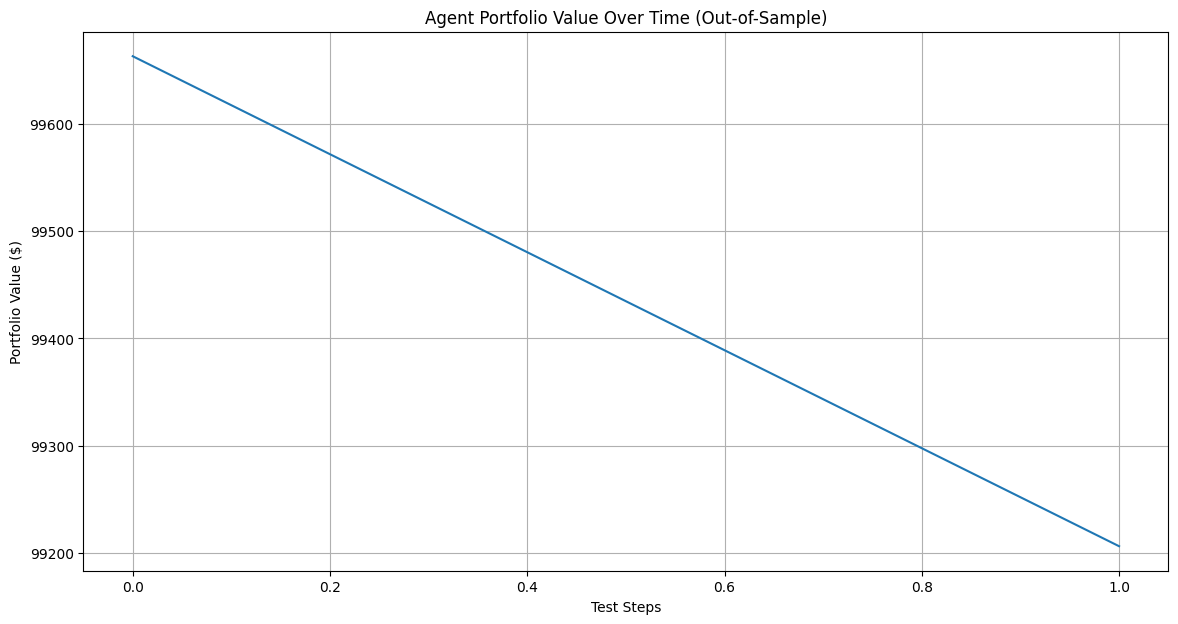

--- Backtest Performance ---
Total Return: -0.46%
Sharpe Ratio (Annualized): nan
Maximum Drawdown: -0.46%


In [7]:
print("Starting out-of-sample evaluation...")
test_start_index = TRAIN_STEPS
obs, _ = wrapped_env.reset(start_index=test_start_index)
done = False
history = []

while not done:
    action, _, _ = agent.act(obs, deterministic=True)
    obs, reward, terminated, truncated, info = wrapped_env.step(action)
    done = terminated or truncated
    history.append(info)

print("Evaluation finished.")
eval_history_df = pd.DataFrame(history)

# 1. Plot the Equity Curve
plt.figure(figsize=(14, 7))
plt.plot(eval_history_df['total_value'])
plt.title('Agent Portfolio Value Over Time (Out-of-Sample)')
plt.xlabel('Test Steps')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()

# 2. Calculate and Print Key Performance Metrics
start_value = eval_history_df['total_value'].iloc[0]
end_value = eval_history_df['total_value'].iloc[-1]
total_return_pct = (end_value / start_value - 1) * 100
returns = eval_history_df['total_value'].pct_change().dropna()
sharpe_ratio = (returns.mean() / (returns.std() + 1e-9)) * np.sqrt(252 * 24 * 60) # Annualized for minutely data
rolling_max = eval_history_df['total_value'].cummax()
drawdown = (eval_history_df['total_value'] - rolling_max) / rolling_max
max_drawdown_pct = drawdown.min() * 100

print("--- Backtest Performance ---")
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")

## Part 4: A Deep Dive into Options Trading

This project also includes a sophisticated environment for trading options. Options are financial derivatives that give the holder the **right, but not the obligation**, to buy or sell an underlying asset at a predetermined price (the *strike price*) before a certain date (the *expiry*).

*   **Call Option:** A bet that the price will go **up**. Gives you the right to *buy*.
*   **Put Option:** A bet that the price will go **down**. Gives you the right to *sell*.

Think of a call option like a non-refundable ticket to buy a concert ticket at face value. If the concert sells out and resale prices skyrocket, your ticket is very valuable. If the concert is unpopular and tickets are cheap, your ticket is worthless, and you only lose the price you paid for it.

### Why Use Options? Defense and Offense

Options are tools of leverage and risk management. They can be used for:

1.  **Hedging (Defense):** To protect an existing portfolio. If you own a lot of stocks, you can buy put options on a market index. If the market crashes, your stocks will lose value, but your puts will gain value, cushioning the blow. This is like buying insurance for your portfolio.
2.  **Speculation (Offense):** To make highly leveraged bets on the direction, volatility, or timing of a market move.

### Combining Stocks and Options: A Hedging Example

Let's demonstrate how buying puts can protect a stock portfolio. We will simulate a market that is trending up and then suddenly crashes. We'll compare an unprotected portfolio to one that bought protective puts.

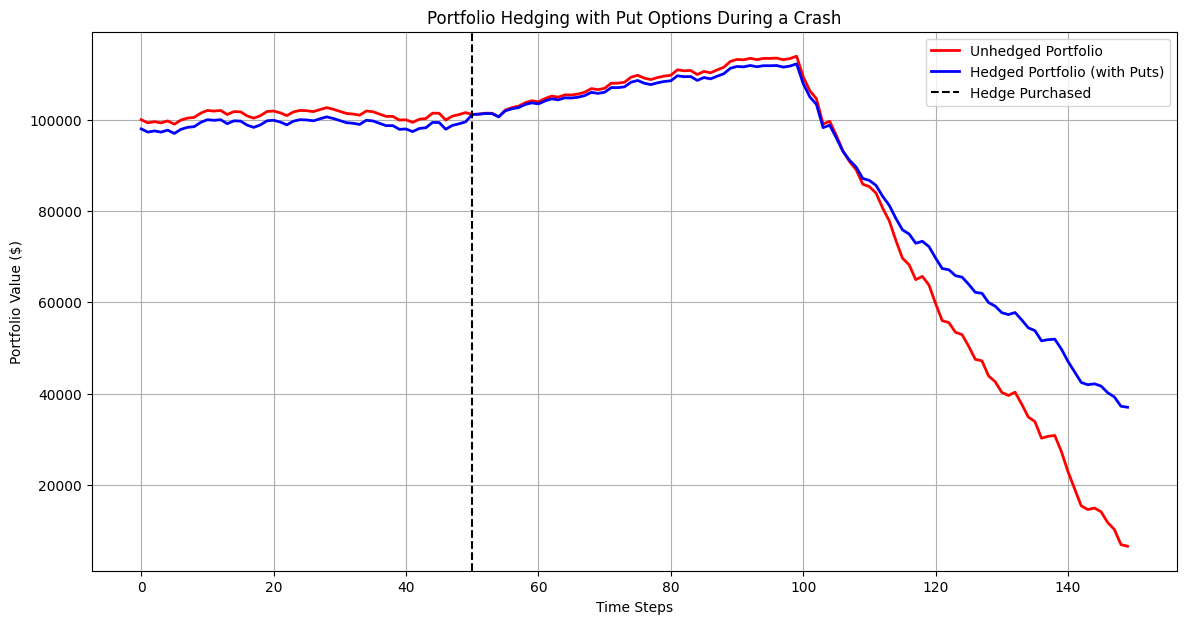

Unhedged portfolio lost: $93,429.59
Hedged portfolio lost:   $60,971.80


In [8]:
def simulate_crash_scenario():
    # Price trends up, then crashes hard
    up_trend = 100 + np.cumsum(np.random.normal(0.1, 0.5, 100))
    crash = up_trend[-1] + np.cumsum(np.random.normal(-2, 1.5, 50))
    return np.concatenate([up_trend, crash])

stock_price = simulate_crash_scenario()
portfolio_value = 100_000 # Initial value
stock_position = portfolio_value / stock_price[0]

# --- UNHEDGED PORTFOLIO ---
unhedged_value = stock_position * stock_price

# --- HEDGED PORTFOLIO ---
# At step 50, we buy put options as insurance. 
# Strike price is 10% below the current market price (Out-of-the-Money).
hedge_point = 50
spot_at_hedge = stock_price[hedge_point]
strike_price = spot_at_hedge * 0.90
tau = (len(stock_price) - hedge_point) / 252.0 # Time to expiry in years
iv = 0.40 # Implied volatility (high, expecting a move)

# Calculate the price of one put option at the hedge point
put_price_at_hedge = bs_price(S=spot_at_hedge, K=strike_price, r=0.01, sigma=iv, tau=tau, option_type='put')

# We use 2% of our portfolio to buy puts
cash_for_hedge = unhedged_value[hedge_point] * 0.02
num_puts = cash_for_hedge / put_price_at_hedge

# Now, calculate the value of the puts throughout the crash
put_values = []
for i in range(hedge_point, len(stock_price)):
    current_tau = (len(stock_price) - i) / 252.0
    put_value = bs_price(S=stock_price[i], K=strike_price, r=0.01, sigma=iv, tau=current_tau, option_type='put')
    put_values.append(put_value * num_puts)

# The value of the hedged portfolio is the stock value + the put value, minus the initial cost of the hedge
hedged_stock_value = (stock_position * stock_price) - cash_for_hedge
hedged_value = np.copy(hedged_stock_value)
hedged_value[hedge_point:] += np.array(put_values)

# Plot the comparison
plt.figure(figsize=(14, 7))
plt.plot(unhedged_value, label='Unhedged Portfolio', lw=2, color='red')
plt.plot(hedged_value, label='Hedged Portfolio (with Puts)', lw=2, color='blue')
plt.axvline(hedge_point, color='k', linestyle='--', label='Hedge Purchased')
plt.title('Portfolio Hedging with Put Options During a Crash')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Unhedged portfolio lost: ${unhedged_value[0] - unhedged_value[-1]:,.2f}")
print(f"Hedged portfolio lost:   ${hedged_value[0] - hedged_value[-1]:,.2f}")

As you can see, the blue line (hedged portfolio) falls much less than the red line. The puts gained value as the market crashed, offsetting a large portion of the losses from the stocks. The cost was a small premium, which slightly reduced the portfolio's value before the crash.

## Part 5: The Frontier - Advanced Improvements

This project provides a powerful and robust foundation, but the journey of building a trading agent is never truly over. Here is a research-backed look at the cutting edge of financial RL, with concrete ways this system can be improved.

### 1. Hierarchical Reinforcement Learning (HRL)

**Concept:** Instead of one monolithic agent making all decisions, HRL uses a multi-level structure. A high-level "manager" agent sets broad strategic goals, and low-level "worker" agents execute them.

**Application in Trading:**
*   **Manager Agent:** Looks at long-term trends and macroeconomic data (like VIX, interest rates). Its action space isn't to buy/sell, but to choose a *strategy* for the workers, e.g., `['Capital Preservation', 'Aggressive Growth', 'Volatility Harvesting']`.
*   **Worker Agents:** Each worker agent is responsible for a specific asset class (e.g., tech stocks, commodities). It receives the manager's strategy as part of its state and executes the actual trades. The 'Aggressive Growth' strategy might give it a reward function that favors high returns, while 'Capital Preservation' would penalize drawdowns heavily.

**Benefit:** This decomposition allows the system to learn strategies at multiple timescales and levels of abstraction, which is a much more realistic model of how human portfolio managers work. It makes the problem more manageable and the resulting strategies more interpretable.

**Reference:** Wang, et al. (2021). *Hierarchical Reinforcement Learning for Automatic Financial Trading*. [AAAI Conference on Artificial Intelligence].

### 2. Offline Reinforcement Learning

**Concept:** The RL agent learns its policy from a large, pre-existing, static dataset of market interactions, without ever interacting with a live or simulated environment during training. This is a paradigm shift from "online" RL, which requires active trial-and-error.

**Application in Trading:** Financial markets are the perfect use case for offline RL. We have decades of historical market data. Training an agent online is slow and can be risky. Offline RL allows us to leverage this vast dataset directly. Algorithms like **Conservative Q-Learning (CQL)** are designed to be pessimistic, avoiding actions that are not well-represented in the historical data, which helps prevent the agent from hallucinating profitable but unrealistic strategies.

**Benefit:** Overcomes the need for a perfect market simulator and allows for learning from massive, real-world datasets. It is inherently safer and can lead to more robust, conservative policies.

**Reference:** Kumar, S., et al. (2020). *Conservative Q-Learning for Offline Reinforcement Learning*. [NeurIPS 2020].

### 3. Integrating Large Language Models (LLMs) for Feature Extraction

**Concept:** The agent's world is currently limited to numerical price data. LLMs (like GPT-4, Llama) can read and understand unstructured text from news articles, social media, and quarterly earnings reports.

**Application in Trading:**
*   **Sentiment Analysis:** An LLM can be fine-tuned to read a news headline like "Company X reports record profits, beating all expectations" and output a strong positive sentiment score. This score becomes a new, powerful feature in the agent's observation space.
*   **Event Detection:** The LLM can identify key events like "FDA approval," "merger announcement," or "CEO resigns" and feed this information to the RL agent.

**Benefit:** This gives the agent a fundamental understanding of the *why* behind price movements, not just the *what*. It can learn to anticipate volatility around earnings or react to market-moving news, a capability purely technical agents lack.

**Reference:** Ding, et al. (2023). *ChatGPT for Financial Time Series Forecasting: A Study of Prompts*. (arXiv preprint).

### 4. Explainable AI (XAI) for RL Policies

**Concept:** A major drawback of deep RL is that the learned policy is a "black box." It's hard to know *why* the agent decided to sell an asset. XAI techniques aim to peek inside this box.

**Application in Trading:** Techniques like SHAP (SHapley Additive exPlanations) can be adapted to analyze an RL agent's decisions. After a backtest, a risk manager could use SHAP to ask, "Why did the agent decide to go all-in on ASSET_2 at this specific time?" The output might show that the most influential factors were a high RSI value, low recent volatility, and a positive sentiment score (if using LLMs). 

**Benefit:** This is crucial for building trust, debugging the agent's behavior, and ensuring the learned strategy aligns with human intuition and risk management principles. No financial institution would deploy a strategy they cannot understand.

**Reference:** Atzmueller, M. (2020). *Explainable Artificial Intelligence (XAI): A Brief Survey and a Case Study on a Recommender System*. (Gesellschaft für Informatik).

## Conclusion

You have now walked through the entire lifecycle of an RL trading agent, from fundamental concepts to practical implementation and evaluation. You've seen how `rl_trading_project` provides a sophisticated, multi-asset framework that realistically simulates market conditions and leverages the power of the PPO algorithm for continuous portfolio optimization. You've also explored how to use options for both defense and offense and have a roadmap for pushing the boundaries with state-of-the-art research.

Remember, RL is a powerful tool, but not a magic bullet. Success requires a deep understanding of the problem, careful data preparation, robust evaluation, and continuous iteration. This project provides the tools to embark on that journey.